# Final implementation

In [ ]:
# @title Connect to drive and helper function
from google.colab import drive
# Mount the drive shared with you.
drive.mount('/content/gdrive', force_remount=True)


import pandas as pd

def open_file(base_path, file_name):
  file_path = base_path + file_name
  try:
      with open(file_path, 'rb') as f:
          loaded_object = pd.read_pickle(f)
      print(f"Successfully loaded object from {file_path}")
      return loaded_object
  except FileNotFoundError:
      print(f"Error: The file {file_path} was not found. Please check the path.")
  except Exception as e:
      print(f"An error occurred: {e}")

base_path = '/content/gdrive/MyDrive/Postgrado/Machine learning/Final_Proyect/'
pkl_folder_path = 'data/alphafoldDB_pdb_1115/'
json_file_path = 'data/deepseq-af2-structures-merged_data-12632.json'

Mounted at /content/gdrive


## Deep seq

In [ ]:
import numpy as np

#@title Load and split json
import json
import random

def load_and_split_json(json_path, train_frac=0.8, val_frac=0.1, seed=42):
    with open(json_path, 'r') as f:
        data = json.load(f)

    all_ids = list(data.keys())
    random.seed(seed)
    random.shuffle(all_ids)

    N = len(all_ids)
    train_ids = all_ids[:int(train_frac * N)]
    val_ids = all_ids[int(train_frac * N):int((train_frac + val_frac) * N)]
    test_ids = all_ids[int((train_frac + val_frac) * N):]

    return data, train_ids, val_ids, test_ids

# Standard amino acids + padding
AMINO_ACID_VOCAB = {
    'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'E': 6, 'Q': 7, 'G': 8, 'H': 9, 'I': 10,
    'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20,
    'X': 21,  # Unknown
    'B': 22,  # Aspartic acid or Asparagine
    'Z': 23   # Glutamic acid or Glutamine
}
PAD_TOKEN_ID = 0

def encode_sequence(seq, max_len=2000):
    """
    Encode an amino acid sequence to a list of integers with padding.
    Unknown amino acids are mapped to 'X'.
    Ensure the output is always a list of integers.
    """
    encoded = [AMINO_ACID_VOCAB.get(aa, AMINO_ACID_VOCAB['X']) for aa in seq]
    if len(encoded) < max_len:
        encoded += [PAD_TOKEN_ID] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]
    return encoded # Return as list of integers

def encode_go_terms(go_terms, go_term_to_index):
    """
    Encode a list of GO terms as a multi-hot binary vector.

    Args:
        go_terms: List of GO term strings, e.g., ['GO:0001234', 'GO:0005678']
        go_term_to_index: Dict mapping GO term → integer index

    Returns:
        numpy array (shape: num_go_terms,) with 1.0 for present terms
    """
    num_go_terms = len(go_term_to_index)
    label_vector = np.zeros(num_go_terms, dtype=np.float32)

    for term in go_terms:
        idx = go_term_to_index.get(term)
        if idx is not None:
            label_vector[idx] = 1.0

    return label_vector

def extract_go_terms_from_json(data):

    all_go_terms = set()

    for protein_id, entry in data.items():
        go_terms = entry.get("true_go", [])
        all_go_terms.update(go_terms)

    # Sort for consistent ordering
    go_term_vocabulary = sorted(list(all_go_terms))
    go_term_to_index = {term: i for i, term in enumerate(go_term_vocabulary)}
    num_go_terms = len(go_term_vocabulary)

    return go_term_vocabulary, go_term_to_index, num_go_terms


def get_sequence_and_labels(data, ids, max_len=2000, go_term_to_index=None):
    X, Y = [], []
    for pid in ids:
        seq = data[pid].get('seq_from_pkl', '')
        go_terms = data[pid].get('true_go', [])
        # encode seq to integers, pad, etc.
        seq_encoded = encode_sequence(seq, max_len)
        go_encoded = encode_go_terms(go_terms, go_term_to_index)
        X.append(seq_encoded)
        Y.append(go_encoded)
    # Convert to numpy arrays with appropriate dtype
    return np.array(X, dtype=np.int32), np.array(Y, dtype=np.float32)

In [ ]:
json_data, train_ids, val_ids, test_ids = load_and_split_json(base_path + json_file_path)
go_term_vocabulary, go_term_to_index, num_go_terms = extract_go_terms_from_json(json_data)

### Model

In [ ]:
#@title Deepseq implementation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dropout, GlobalAveragePooling1D, Dense, BatchNormalization, Activation

# Deep seq model
def build_model(max_sequence_size, num_amino_acids, embedding_dims, num_go_terms): # Changed max_num_functions to num_go_terms
    input_layer = Input(shape=(max_sequence_size,))

    embedding = Embedding(num_amino_acids, embedding_dims, input_length=max_sequence_size)(input_layer)

    x = Conv1D(250, 15, activation='relu', strides=1)(embedding)
    x = Dropout(0.3)(x)
    x = Conv1D(100, 15, activation='relu', strides=1)(x)
    x = Dropout(0.3)(x)

    pooled_output = GlobalAveragePooling1D(name='latent_space')(x)

    x = Dense(num_go_terms)(pooled_output) # Changed max_num_functions to num_go_terms
    x = BatchNormalization()(x)
    output = Activation('sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output)
    latent_model = Model(inputs=input_layer, outputs=pooled_output)  # Para extraer el espacio latente

    return model, latent_model

X_train, y_train = get_sequence_and_labels(json_data, train_ids, go_term_to_index=go_term_to_index)
X_val, y_val = get_sequence_and_labels(json_data, val_ids, go_term_to_index=go_term_to_index)

# Hyperparameters
max_sequence_size = 2000
num_amino_acids = 24     # 23 aminoácidos + padding (0)
embedding_dims = 23
# The number of output units should match the number of GO terms
# max_num_functions = 5        # O las etiquetas multilabel reales
# Use the calculated number of unique GO terms
num_go_terms = len(go_term_to_index)


model, latent_model = build_model(max_sequence_size, num_amino_acids, embedding_dims, num_go_terms) # Passed num_go_terms

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # multilabel
              metrics=['accuracy'])

# Initial training
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=64)

# Get latent space representation
X_latent_train = latent_model.predict(X_train, batch_size=64)
X_latent_val   = latent_model.predict(X_val, batch_size=64)
#X_latent_test  = latent_model.predict(X_test, batch_size=64)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 33s 147ms/step - accuracy: 0.0847 - loss: 0.6744 - val_accuracy: 0.2193 - val_loss: 0.6200
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.1051 - loss: 0.6032 - val_accuracy: 0.1607 - val_loss: 0.5548
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.0487 - loss: 0.5400 - val_accuracy: 0.0000e+00 - val_loss: 0.4973
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.0476 - loss: 0.4843 - val_accuracy: 0.0000e+00 - val_loss: 0.4474
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.0546 - loss: 0.4353 - val_accuracy: 0.0000e+00 - val_loss: 0.4041
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.0662 - loss: 0.3921 - val_accuracy: 0.0103 - val_loss: 0.3634
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.0627 - loss: 0.3541 - val_accuracy: 0.0333 - val_loss: 0.3294
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.0748 - lo

In [ ]:
# create dictionary pair protein latent: representation
x_train_dict = {}
for i, protein_id in enumerate(train_ids):
    x_train_dict[protein_id] = X_latent_train[i]

x_val_dict = {}
for i, protein_id in enumerate(val_ids):
    x_val_dict[protein_id] = X_latent_val[i]

## Structure

In [ ]:
#@title Modified Data Loader for Latent Space Representations
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
import json
import pandas as pd
import ast

class JsonDataLoaderWithLatentSpace(tf.keras.utils.Sequence):
    """
    Modified Keras Sequence for loading protein data with pre-computed latent representations
    from DeepSeq model instead of ESM embeddings.
    """
    def __init__(self, in_data, batch_size, go_term_vocabulary,
                 go_term_to_index, latent_representations_dict, latent_dim=100,
                 coords_mask_plddt_th=70.0, pad_token_id=0, fixed_max_len=1024):
        """
        Args:
            latent_representations_dict: Dictionary mapping protein_id -> latent_vector
                                       where latent_vector is the output from your DeepSeq latent_model
            latent_dim: Dimension of the latent space (100 in your DeepSeq model with GlobalAveragePooling1D)
            fixed_max_len: The fixed maximum sequence length to use for padding.
        """
        self.in_data = in_data
        self.batch_size = batch_size
        self.coords_mask_plddt_th = coords_mask_plddt_th
        self.pad_token_id = pad_token_id
        self.latent_dim = latent_dim
        self.fixed_max_len = fixed_max_len # Use a fixed maximum length

        # GO term encoding
        self.go_term_vocabulary = go_term_vocabulary
        self.go_term_to_index = go_term_to_index
        self.num_go_terms = len(go_term_vocabulary)

        # Latent representations from DeepSeq model
        self.latent_representations = latent_representations_dict


        # Filter protein IDs to only include those with latent representations
        all_protein_ids = set(in_data.keys())
        latent_protein_ids = set(self.latent_representations.keys())
        self.protein_ids = list(all_protein_ids.intersection(latent_protein_ids))

        print(f"Total proteins in JSON: {len(all_protein_ids)}")
        print(f"Proteins with latent representations: {len(latent_protein_ids)}")
        print(f"Final dataset size: {len(self.protein_ids)}")

    def __len__(self):
        return int(tf.math.ceil(len(self.protein_ids) / self.batch_size))

    def encode_go_terms(self, go_terms_list):
        """Convert list of GO terms to multi-hot encoded vector"""
        label_vector = np.zeros(self.num_go_terms, dtype=np.float32)
        if go_terms_list:  # Check if list is not empty
            for go_term in go_terms_list:
                if go_term in self.go_term_to_index:
                    label_vector[self.go_term_to_index[go_term]] = 1.0
        return label_vector

    def create_latent_sequence_representation(self, protein_ids):
        """
        Create sequence-like representation from latent vectors.
        Since your structural model expects sequence input, we need to broadcast
        the latent vector across sequence positions.
        """
        batch_latent_seqs = []

        for protein_id in protein_ids:
            if protein_id in self.latent_representations:
                # Get the latent vector (shape: latent_dim,)
                latent_vector = self.latent_representations[protein_id]

                # Ensure it's a numpy array with correct shape
                if isinstance(latent_vector, tf.Tensor):
                    latent_vector = latent_vector.numpy()
                latent_vector = np.array(latent_vector, dtype=np.float32)

                # If latent_vector is 1D, reshape to (latent_dim,)
                if latent_vector.ndim > 1:
                    latent_vector = latent_vector.flatten()

                # Broadcast latent vector across sequence length
                # Shape: (max_len, latent_dim)
                latent_seq = np.tile(latent_vector[np.newaxis, :], (self.fixed_max_len, 1)) # Use fixed_max_len

            else:
                # Fallback: create zero vector if latent representation not found
                print(f"Warning: No latent representation found for {protein_id}")
                latent_seq = np.zeros((self.fixed_max_len, self.latent_dim), dtype=np.float32) # Use fixed_max_len

            batch_latent_seqs.append(latent_seq)

        return np.array(batch_latent_seqs, dtype=np.float32)

    def pad_coords(self, coords_list):
        """Pad coordinates with zero values and handle invalid coords"""
        padded_coords = []
        for coords in coords_list:
            if not coords:  # Handle empty coords
                coords_array = np.zeros((self.fixed_max_len, 3, 3), dtype=np.float32) # Use fixed_max_len
            else:
                coords_array = np.array(coords, dtype=np.float32)
                # Replace any inf or nan values with 0
                coords_array = np.nan_to_num(coords_array, nan=0.0, posinf=0.0, neginf=0.0)

                if len(coords_array) < self.fixed_max_len:
                    pad_shape = list(coords_array.shape)
                    pad_shape[0] = self.fixed_max_len - coords_array.shape[0]
                    padding = np.zeros(pad_shape, dtype=np.float32)
                    coords_array = np.concatenate([coords_array, padding], axis=0)
                else:
                    coords_array = coords_array[:self.fixed_max_len]

            padded_coords.append(coords_array)
        return np.array(padded_coords)

    def pad_plddts(self, plddts_list):
        """Pad pLDDT scores with 0 for padding, normalize to 0-1 range"""
        padded_plddts = []
        for plddt in plddts_list:
            if not plddt:  # Handle empty plddt
                plddt_array = np.zeros(self.fixed_max_len, dtype=np.float32) # Use fixed_max_len
            else:
                plddt_array = np.array(plddt, dtype=np.float32)
                # Clamp pLDDT values to valid range [0, 100] before normalization
                plddt_array = np.clip(plddt_array, 0.0, 100.0)
                plddt_array = plddt_array / 100.0  # Normalize to 0-1 range

                if len(plddt_array) < self.fixed_max_len:
                    padding = np.zeros(self.fixed_max_len - len(plddt_array), dtype=np.float32) # Use fixed_max_len
                    plddt_array = np.concatenate([plddt_array, padding])
                else:
                    plddt_array = plddt_array[:self.fixed_max_len]

            padded_plddts.append(plddt_array)
        return np.array(padded_plddts)

    def create_padding_mask(self, sequences):
        """Create padding mask (1 for real tokens, 0 for padding)"""
        masks = []
        for seq in sequences:
            seq_len = len(seq) if seq else 0

            # Ensure we have at least one valid token to prevent all-zero masks
            if seq_len == 0:
                seq_len = 1  # Set minimum length to 1

            mask = np.ones(seq_len, dtype=np.float32)
            if seq_len < self.fixed_max_len: # Use fixed_max_len
                padding_mask = np.zeros(self.fixed_max_len - seq_len, dtype=np.float32) # Use fixed_max_len
                full_mask = np.concatenate([mask, padding_mask])
            else:
                full_mask = mask[:self.fixed_max_len] # Use fixed_max_len

            # Final safety check: ensure at least one valid position
            if np.sum(full_mask) == 0:
                full_mask[0] = 1.0  # Set first position as valid

            masks.append(full_mask)
        return np.array(masks)

    def mask_coords_by_plddt(self, coords, plddts):
        """Mask coordinates where pLDDT < threshold"""
        threshold = self.coords_mask_plddt_th / 100.0
        bad_coords_mask = plddts < threshold

        # Use 0.0 for masked pLDDT to maintain valid range
        masked_plddts = np.where(bad_coords_mask, 0.0, plddts)

        if coords.ndim == 4:  # (batch, seq_len, 3, 3)
            expanded_mask = bad_coords_mask[..., np.newaxis, np.newaxis]
        elif coords.ndim == 3:  # (batch, seq_len, 3)
            expanded_mask = bad_coords_mask[..., np.newaxis]
        else:
            expanded_mask = bad_coords_mask

        # Use 0.0 for masked coordinates
        masked_coords = np.where(expanded_mask, 0.0, coords)

        # Final safety check to remove any remaining inf/nan
        masked_coords = np.nan_to_num(masked_coords, nan=0.0, posinf=0.0, neginf=0.0)
        masked_plddts = np.nan_to_num(masked_plddts, nan=0.0, posinf=0.0, neginf=0.0)

        return masked_coords, masked_plddts

    def __getitem__(self, idx):
        # Get batch protein IDs
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.protein_ids))
        batch_ids = self.protein_ids[start_idx:end_idx]

        # Collect batch data
        batch_data = []
        for protein_id in batch_ids:
            loaded_object = self.in_data.get(protein_id, {})
            if loaded_object:
                extracted_data = {
                    'protein': protein_id,
                    'seq': loaded_object.get('seq_from_pkl', ''),
                    'true_go': loaded_object.get('true_go', []),
                    'coords': loaded_object.get('coords', []),
                    'plddt': loaded_object.get('plddt', [])
                }
                batch_data.append(extracted_data)

        if not batch_data:
            return self._empty_batch()

        # Extract data
        sequences = [item['seq'] for item in batch_data]
        coords_list = [item['coords'] for item in batch_data]
        plddts_list = [item['plddt'] for item in batch_data]
        true_gos_list = [item['true_go'] for item in batch_data]

        # Apply padding for structural data using fixed_max_len
        padded_coords = self.pad_coords(coords_list)
        padded_plddts = self.pad_plddts(plddts_list)
        padding_mask = self.create_padding_mask(sequences)

        # Apply coordinate masking based on pLDDT
        masked_coords, masked_plddts = self.mask_coords_by_plddt(padded_coords, padded_plddts)

        # Create latent sequence representations instead of ESM embeddings
        latent_sequences = self.create_latent_sequence_representation(batch_ids)

        # Encode GO terms to multi-hot labels
        go_labels = []
        for go_terms in true_gos_list:
            encoded_labels = self.encode_go_terms(go_terms)
            go_labels.append(encoded_labels)
        go_labels = np.array(go_labels)

        # Ensure at least one positive label per sample to avoid all-zero targets
        for i, label in enumerate(go_labels):
            if np.sum(label) == 0:  # If no GO terms are found
                # Set a small probability for the first GO term to avoid all-zero labels
                go_labels[i, 0] = 0.01

        # Return model inputs and labels
        return (
            {
                'dpseq': tf.constant(latent_sequences, dtype=tf.float32),  # Now contains latent representations
                'coords': tf.constant(masked_coords, dtype=tf.float32),
                'padding_mask': tf.constant(padding_mask, dtype=tf.float32)
            },
            tf.constant(go_labels, dtype=tf.float32)
        )

    def _empty_batch(self):
        """Return empty batch when no data is available"""
        batch_size = 1
        # Use fixed_max_len for empty batch shape
        seq_len = self.fixed_max_len
        return (
            {
                'dpseq': tf.constant(np.zeros((batch_size, seq_len, self.latent_dim)), dtype=tf.float32),
                'coords': tf.constant(np.zeros((batch_size, seq_len, 3, 3)), dtype=tf.float32),
                'padding_mask': tf.constant(np.zeros((batch_size, seq_len)), dtype=tf.float32)
            },
            tf.constant(np.zeros((batch_size, self.num_go_terms)), dtype=tf.float32)
        )

In [ ]:
#@title Structural model
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Lambda
import numpy as np
import json
import pandas as pd
import ast

# Custom layers for your model
class PrepareAttentionMask(layers.Layer):
    """Custom layer to prepare a boolean padding mask for MultiHeadAttention."""
    def call(self, inputs):
        boolean_mask = tf.cast(1 - inputs, tf.bool)
        expanded_mask = boolean_mask[:, tf.newaxis, tf.newaxis, :]
        return expanded_mask

class PreparePoolingMask(layers.Layer):
    """Custom layer to prepare a boolean padding mask for GlobalAveragePooling1D."""
    def call(self, inputs):
        boolean_mask = tf.cast(1 - inputs, tf.bool)
        return boolean_mask

class SafeClipLayer(layers.Layer):
    """Improved clipping layer with gradient-safe operations"""
    def __init__(self, clip_value_min=-10.0, clip_value_max=10.0, **kwargs):
        super().__init__(**kwargs)
        self.clip_value_min = clip_value_min
        self.clip_value_max = clip_value_max

    def call(self, inputs):
        # First remove any inf/nan values
        inputs = tf.where(tf.math.is_finite(inputs), inputs, 0.0)
        # Then clip to prevent extreme values
        #clip_val = tf.clip_by_value(inputs, self.clip_value_min, self.clip_value_max)
        return tf.clip_by_value(inputs, self.clip_value_min, self.clip_value_max)
        #return tf.debugging.check_numerics(clip_val, "Clip mask have NaN/Inf")


    def get_config(self):
        config = super().get_config()
        config.update({
            'clip_value_min': self.clip_value_min,
            'clip_value_max': self.clip_value_max
        })
        return config

class DihedralLayer(tf.keras.layers.Layer):
    """Layer for computing dihedral angles from protein backbone coordinates (N, CA, C)"""

    def __init__(self, eps=1e-7, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def call(self, coords):
        # coords shape: (batch_size, seq_len, 3, 3) - atoms N, CA, C
        # Step 1: Reshape to (batch_size, 3 * seq_len, 3)
        batch_size = tf.shape(coords)[0]
        seq_len = tf.shape(coords)[1]
        coords_flat = tf.reshape(coords[:, :, :3, :], [batch_size, seq_len * 3, 3])

        # Step 2: Compute link vectors (bond directions)
        dX = coords_flat[:, 1:, :] - coords_flat[:, :-1, :]

        # Step 3: Normalize bond vectors
        U = tf.math.l2_normalize(dX + self.eps, axis=-1)

        # Step 4: Get consecutive vectors
        u_2 = U[:, :-2, :]
        u_1 = U[:, 1:-1, :]
        u_0 = U[:, 2:, :]

        # Step 5: Compute normals to planes formed by the vectors
        n_2 = tf.linalg.cross(u_2, u_1)
        n_1 = tf.linalg.cross(u_1, u_0)

        # Step 6: Normalize the normals
        n_2 = tf.math.l2_normalize(n_2 + self.eps, axis=-1)
        n_1 = tf.math.l2_normalize(n_1 + self.eps, axis=-1)

        # Step 7: Compute cosine and angle sign
        cosD = tf.reduce_sum(n_2 * n_1, axis=-1)
        cosD = tf.clip_by_value(cosD, -1.0 + self.eps, 1.0 - self.eps)

        angle = tf.acos(cosD)
        sign = tf.sign(tf.reduce_sum(u_2 * n_1, axis=-1))
        D = sign * angle  # Dihedral angle

        # Step 8: Pad D to align with residues (phi, psi, omega)
        D_padded = tf.pad(D, [[0, 0], [1, 2]], mode='CONSTANT')  # (batch, 3*res-3 + 3) = 3*res
        D_reshaped = tf.reshape(D_padded, [batch_size, seq_len, 3])

        # Step 9: Convert to circular features
        dihedral_features = tf.concat([
            tf.math.cos(D_reshaped),
            tf.math.sin(D_reshaped)
        ], axis=-1)  # shape: (batch_size, seq_len, 6)

        return dihedral_features

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], 6)

    def get_config(self):
        config = super().get_config()
        config.update({'eps': self.eps})
        return config

def masked_mean(tensor, mask):
    mask = tf.cast(mask, tf.float32)
    mask = tf.expand_dims(mask, axis=-1)  # (batch, seq_len, 1)
    tensor *= mask
    summed = tf.reduce_sum(tensor, axis=1)
    mask_sum = tf.reduce_sum(mask, axis=1)
    mask_sum = tf.where(mask_sum == 0, tf.ones_like(mask_sum), mask_sum)  # prevent divide-by-zero
    return summed / mask_sum




def build_model_transformer(
    esm_dim,
    embed_dim,
    num_layers,
    num_heads,
    num_go_terms,
    dropout_rate=0.1,
    max_seq_len=1024 # This is now fixed in the data loader
):
    # Inputs
    dpseq_in = Input(shape=(max_seq_len, esm_dim), name="dpseq") # Use fixed max_seq_len
    coords_in = Input(shape=(max_seq_len, 3, 3), name="coords") # Use fixed max_seq_len
    padding_mask_in = Input(shape=(max_seq_len,), dtype=tf.float32, name="padding_mask") # Use fixed max_seq_len

    # ESM Projection with improved initialization and normalization
    dpseq_proj = layers.Dense(
        embed_dim,
        activation=None,  # Apply activation separately
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros'
    )(dpseq_in)
    dpseq_proj = Lambda(lambda x: tf.debugging.check_numerics(x, message="NaNs in dpseq_proj after dense layer"))(dpseq_proj)
    dpseq_proj = layers.LayerNormalization()(dpseq_proj)
    dpseq_proj = layers.Activation('gelu')(dpseq_proj)
    dpseq_proj = Lambda(lambda x: tf.debugging.check_numerics(x, message="NaNs in dpseq_proj before SafeClipLayer"))(dpseq_proj)
    dpseq_proj = SafeClipLayer(clip_value_min=-5.0, clip_value_max=5.0)(dpseq_proj)

    # Dihedral Embedding with improved stability
    dihedral_layer = DihedralLayer(eps=1e-7, name="dihedral_layer")
    dihedral_features = dihedral_layer(coords_in)
    dihedral_emb = layers.Dense(
        embed_dim,
        activation='tanh',
        name='dihedral_projection'
    )(dihedral_features)
    dihedral_emb = Lambda(lambda x: tf.debugging.check_numerics(x, message="NaNs in dihedral_emb before dense layer"))(dihedral_emb)
    dihedral_emb = layers.LayerNormalization(epsilon=1e-6)(dihedral_emb)
    dihedral_emb = SafeClipLayer(clip_value_min=-5.0, clip_value_max=5.0)(dihedral_emb)
    dihedral_emb = Lambda(lambda x: tf.debugging.check_numerics(x, message="NaNs in dihedral_emb after SafeClipLayer"))(dihedral_emb)

    # Combine embeddings with residual connection and normalization
    embed = layers.Add()([dihedral_emb, dpseq_proj])
    embed = layers.LayerNormalization(epsilon=1e-6)(embed)  # Larger epsilon for stability
    embed = layers.Dropout(dropout_rate)(embed)
    embed = Lambda(lambda x: tf.debugging.check_numerics(x, message="NaNs in embed after dropout"))(embed)

    # Prepare attention mask
    attention_mask = PrepareAttentionMask()(padding_mask_in)

    # Transformer Encoder with improved stability
    x = embed
    for i in range(num_layers):
        # Multi-Head Attention with proper normalization
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            dropout=dropout_rate,
            kernel_initializer='glorot_uniform'
        )(x, x, attention_mask=attention_mask)

        # Pre-norm residual connection
        x_normed = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Add()([x, layers.Dropout(dropout_rate)(attention_output)])

        # Feed Forward Network with pre-normalization
        x_normed = layers.LayerNormalization(epsilon=1e-6)(x)
        ff_dim = embed_dim * 2
        feed_forward_output = layers.Dense(
            ff_dim,
            activation="relu",
            kernel_initializer='glorot_uniform'
        )(x_normed)
        feed_forward_output = layers.Dropout(dropout_rate)(feed_forward_output)
        feed_forward_output = layers.Dense(
            embed_dim,
            kernel_initializer='glorot_uniform'
        )(feed_forward_output)

        # Residual connection
        x = layers.Add()([x, layers.Dropout(dropout_rate)(feed_forward_output)])

    # Final layer normalization
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = Lambda(lambda x: tf.debugging.check_numerics(x, message="NaNs in final layer normalization"))(x)

    # Global Average Pooling with mask
    boolean_pooling_mask = PreparePoolingMask()(padding_mask_in)
    pooled_output = Lambda(lambda args: masked_mean(args[0], args[1]), name="safe_masked_mean")([x, boolean_pooling_mask])
    #pooled_output = layers.GlobalAveragePooling1D()(x, mask=boolean_pooling_mask)
    pooled_output = Lambda(lambda x: tf.debugging.check_numerics(x, message="NaNs in pooled_output before dense layer"))(pooled_output)

    # Additional processing layers with proper initialization
    pooled_output = layers.Dense(
        embed_dim // 2,
        activation='relu',
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros'
    )(pooled_output)
    pooled_output = layers.LayerNormalization(epsilon=1e-6)(pooled_output)
    pooled_output = layers.Dropout(dropout_rate)(pooled_output)

    # GO term prediction with careful initialization
    go_terms_output = layers.Dense(
        num_go_terms,
        activation="sigmoid",
        name="go_terms_output",
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        bias_initializer='zeros'
    )(pooled_output)

    return Model(
        inputs=[dpseq_in, coords_in, padding_mask_in],
        outputs=go_terms_output,
        name="gvp_transformer_encoder_with_go_output"
    )


def setup_training_with_latent_space(json_data, train_latent_dict, val_latent_dict, go_term_vocabulary, go_term_to_index, num_go_terms, latent_dim=100, fixed_max_len=1024):
    """
    Modified setup function that uses latent space representations and extracts
    GO terms directly from the JSON structure file.

    Args:
        latent_representations_dict: Dictionary mapping protein_id -> latent_vector
        latent_dim: Dimension of the latent space (default 100 for GlobalAveragePooling1D)
        fixed_max_len: The fixed maximum sequence length to use for padding.
    """

    # Create data loader
    data_loader = JsonDataLoaderWithLatentSpace(
        in_data=json_data,
        batch_size=32,
        go_term_vocabulary=go_term_vocabulary,
        go_term_to_index=go_term_to_index,
        latent_representations_dict=train_latent_dict,
        latent_dim=latent_dim,
        coords_mask_plddt_th=70.0,
        fixed_max_len=fixed_max_len # Pass fixed_max_len to data loader
    )

    val_loader = JsonDataLoaderWithLatentSpace(
        in_data=json_data,
        batch_size=4,
        go_term_vocabulary=go_term_vocabulary,
        go_term_to_index=go_term_to_index,
        latent_representations_dict=val_latent_dict,
        latent_dim=latent_dim,
        coords_mask_plddt_th=70.0,
        fixed_max_len=fixed_max_len # Pass fixed_max_len to data loader
    )

    # Build model - you need to modify the esm_dim parameter to match your latent_dim
    model = build_model_transformer(
        esm_dim=latent_dim,  # Changed from 1280 to your latent dimension
        embed_dim=120,
        num_layers=2,
        num_heads=4,
        num_go_terms=num_go_terms,
        dropout_rate=0.1,
        max_seq_len=fixed_max_len # Pass fixed_max_len to model builder
    )

    # Custom optimizer with gradient clipping and lower learning rate
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=1e-4,  # Lower learning rate
        #weight_decay=1e-4,   # Add weight decay
        clipnorm=1.0,        # Aggressive gradient clipping
        epsilon=1e-8         # Larger epsilon for numerical stability
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['binary_accuracy'],
        run_eagerly=False  # Set to True for debugging
    )

    # Enhanced callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        tf.keras.callbacks.TerminateOnNaN(),  # Stop training if NaN is encountered
        tf.keras.callbacks.LambdaCallback(
            on_batch_end=lambda batch, logs: print(f"Batch {batch}: loss={logs.get('loss', 'N/A'):.6f}")
            if batch % 10 == 0 else None
        )
    ]

    return model, data_loader, callbacks, val_loader

# Debug and validation functions
def debug_model_inputs(data_loader, model):
    """Debug function to check for NaN/Inf values in data"""
    print("Debugging first batch...")
    try:
        batch_inputs, batch_labels = data_loader[0]

        print(f"Batch inputs shapes:")
        for key, value in batch_inputs.items():
            print(f"  {key}: {value.shape}")
            has_nan = tf.reduce_any(tf.math.is_nan(value))
            has_inf = tf.reduce_any(tf.math.is_inf(value))
            min_val = tf.reduce_min(value)
            max_val = tf.reduce_max(value)
            print(f"    NaN: {has_nan}, Inf: {has_inf}")
            print(f"    Range: [{min_val:.6f}, {max_val:.6f}]")

        print(f"Labels shape: {batch_labels.shape}")
        print(f"Labels sum per sample: {tf.reduce_sum(batch_labels, axis=1)}")
        print(f"Labels NaN: {tf.reduce_any(tf.math.is_nan(batch_labels))}")

        # Test model prediction
        print("Testing model prediction...")
        pred = model(batch_inputs, training=False)
        print(f"Prediction shape: {pred.shape}")
        print(f"Prediction range: [{tf.reduce_min(pred):.6f}, {tf.reduce_max(pred):.6f}]")
        print(f"Prediction NaN: {tf.reduce_any(tf.math.is_nan(pred))}")

        return True

    except Exception as e:
        print(f"Error in debugging: {e}")
        import traceback
        traceback.print_exc()
        return False

# Main execution
if __name__ == "__main__":
    # Setup training
    #json_data, train_ids, val_ids, test_ids = load_and_split_json(base_path + json_file_path)
    # go_term_vocabulary, go_term_to_index, num_go_terms = extract_go_terms_from_json(json_data)
    # x_train_dic, x_val_dic

    # Use a fixed max_len when setting up the training
    fixed_max_len = 1024
    model, data_loader, callbacks, val_loader = setup_training_with_latent_space(json_data, x_train_dict, x_val_dict, go_term_vocabulary, go_term_to_index, num_go_terms, fixed_max_len=fixed_max_len)

    # Debug first
    if debug_model_inputs(data_loader, model):
        print("Starting training...")
        try:
            history = model.fit(
                data_loader,
                epochs=5,
                callbacks=callbacks,
                verbose=1,
                validation_data=val_loader  # Add validation data if available
            )
            print("Training completed successfully!")
        except Exception as e:
            print(f"Training error: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("Debug failed, please check your data.")

Total proteins in JSON: 12632
Proteins with latent representations: 10105
Final dataset size: 10105
Total proteins in JSON: 12632
Proteins with latent representations: 1263
Final dataset size: 1263
Debugging first batch...
Batch inputs shapes:
  dpseq: (32, 1024, 100)
    NaN: False, Inf: False
    Range: [0.000000, 0.300855]
  coords: (32, 1024, 3, 3)
    NaN: False, Inf: False
    Range: [-102.825996, 78.005997]
  padding_mask: (32, 1024)
    NaN: False, Inf: False
    Range: [0.000000, 1.000000]
Labels shape: (32, 10236)
Labels sum per sample: [ 48. 106.   4.  62.  74.   4.  60. 120.  26. 199.  93.  49. 184.  17.
  86.  46.  20. 103.  59.   4.  26. 100.  39. 109.  43.  37.  18.  10.
  55.  67.   4.  53.]
Labels NaN: False
Testing model prediction...
Prediction shape: (32, 10236)
Prediction range: [0.423007, 0.573793]
Prediction NaN: False
Starting training...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Batch 0: loss=0.694532
 10/316 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - binary_accuracy: 0.5504 - loss: 0.6892Batch 10: loss=0.682360
 20/316 ━━━━━━━━━━━━━━━━━━━━ 45s 154ms/step - binary_accuracy: 0.6103 - loss: 0.6828Batch 20: loss=0.668966
 30/316 ━━━━━━━━━━━━━━━━━━━━ 44s 154ms/step - binary_accuracy: 0.6608 - loss: 0.6762Batch 30: loss=0.655498
 40/316 ━━━━━━━━━━━━━━━━━━━━ 42s 154ms/step - binary_accuracy: 0.7010 - loss: 0.6695Batch 40: loss=0.641847
 50/316 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - binary_accuracy: 0.7326 - loss: 0.6627Batch 50: loss=0.628493
 60/316 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - binary_accuracy: 0.7578 - loss: 0.6560Batch 60: loss=0.615245
 70/316 ━━━━━━━━━━━━━━━━━━━━ 38s 158ms/step - binary_accuracy: 0.7782 - loss: 0.6494Batch 70: loss=0.602141
 80/316 ━━━━━━━━━━━━━━━━━━━━ 37s 158ms/step - binary_accuracy: 0.7950 - loss: 0.6427Batch 80: loss=0.589580
 90/316 ━━━━━━━━━━━━━━━━━━━━ 35s 158ms/step - binary_accuracy: 0.8092 - loss: 0.6362Batch 90: loss=0.577359
100/3

In [ ]:
model.summary()

Model: "gvp_transformer_encoder_with_go_output"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ coords (InputLayer) │ (None, 1024, 3,   │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dpseq (InputLayer)  │ (None, 1024, 100) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dihedral_layer      │ (None, 1024, 6)   │          0 │ coords[0][0]      │
│ (DihedralLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024, 120) │     12,120 │ dpseq[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dihedral_projection │ (None, 1024, 120) │        840 │ dihedral_layer[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1024, 120) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1024, 120) │          0 │ dihedral_project… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1024, 120) │        240 │ lambda[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1024, 120) │        240 │ lambda_2[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1024, 120) │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ safe_clip_layer_1   │ (None, 1024, 120) │          0 │ layer_normalizat… │
│ (SafeClipLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1024, 120) │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1024, 120) │          0 │ safe_clip_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ safe_clip_layer     │ (None, 1024, 120) │          0 │ lambda_1[0][0]    │
│ (SafeClipLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1024, 120) │          0 │ lambda_3[0][0],   │
│                     │                   │            │ safe_clip_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1024, 120) │        240 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1024, 120) │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 1024, 120) │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,634,770 (10.05 MB)

 Trainable params: 878,256 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,756,514 (6.70 MB)

# Results

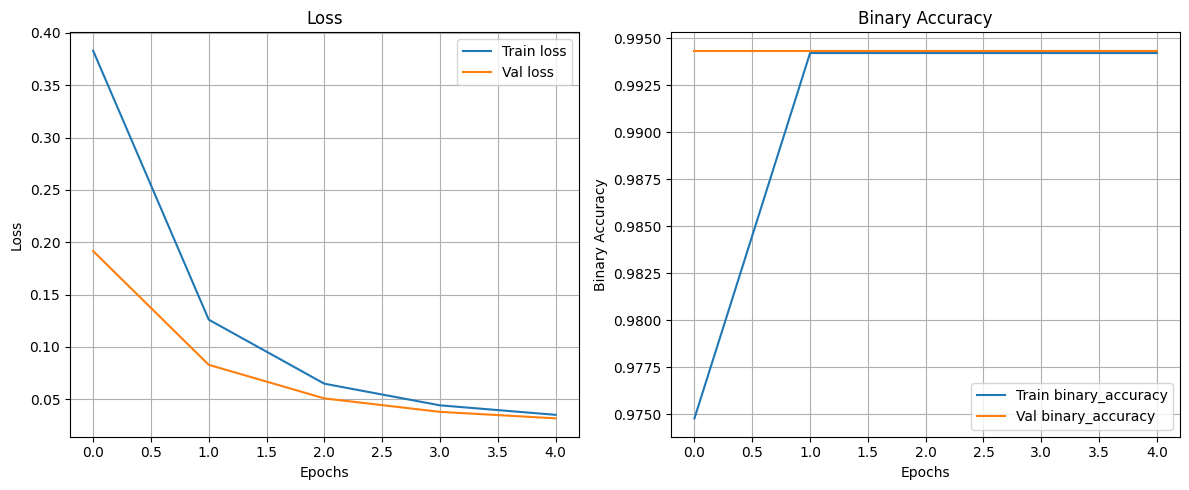

In [ ]:
#@title Plot loss and accuracy
import matplotlib.pyplot as plt

def plot_training_history(history, metrics_to_plot=["loss", "binary_accuracy"]):
    """
    Plots training history for given metrics.

    Args:
        history: Keras History object returned by model.fit()
        metrics_to_plot: List of metrics to plot. Common options: ['loss', 'binary_accuracy']
    """
    if not history or not hasattr(history, "history"):
        print("Invalid history object.")
        return

    history_dict = history.history

    plt.figure(figsize=(12, 5))

    for i, metric in enumerate(metrics_to_plot):
        plt.subplot(1, len(metrics_to_plot), i + 1)
        plt.plot(history_dict[metric], label=f"Train {metric}")
        val_metric = f"val_{metric}"
        if val_metric in history_dict:
            plt.plot(history_dict[val_metric], label=f"Val {metric}")
        plt.title(metric.replace('_', ' ').title())
        plt.xlabel("Epochs")
        plt.ylabel(metric.replace('_', ' ').title())
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_training_history(history)

In [ ]:
# Step 1: Get labels
X_test_seq, y_test = get_sequence_and_labels(json_data, test_ids, go_term_to_index=go_term_to_index)

# Step 2: Get latent space from pretrained sequence model
X_latent_test = latent_model.predict(X_test_seq, batch_size=64)

# Step 3: Build a dictionary with latent vectors keyed by protein_id
x_test_dict = {}
for i, protein_id in enumerate(test_ids):  # ← use test_ids, not val_ids
    x_test_dict[protein_id] = X_latent_test[i]

# Step 4: Create the test dataset using your custom loader
test_loader = JsonDataLoaderWithLatentSpace(
    in_data=json_data,
    batch_size=4,
    go_term_vocabulary=go_term_vocabulary,
    go_term_to_index=go_term_to_index,
    latent_representations_dict=x_test_dict,
    latent_dim=100,
    coords_mask_plddt_th=70.0,
    fixed_max_len=fixed_max_len # Pass fixed_max_len to data loader
)

# Step 5: Evaluate the model
results = model.evaluate(test_loader)
print(f"\nTest Results: Loss = {results[0]:.4f}, Binary Accuracy = {results[1]:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
Total proteins in JSON: 12632
Proteins with latent representations: 1264
Final dataset size: 1264
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - binary_accuracy: 0.9944 - loss: 0.0317

Test Results: Loss = 0.0324, Binary Accuracy = 0.9942


In [ ]:
pred = model.predict(test_loader)

316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Convert probabilities to binary predictions
y_pred_binary = (pred > 0.5).astype(int)

# Calculate metrics
precision = precision_score(y_test, y_pred_binary, average='micro')
recall = recall_score(y_test, y_pred_binary, average='micro')
f1 = f1_score(y_test, y_pred_binary, average='micro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.6938
Recall: 0.1193
F1-score: 0.2036
